# Project 1: Cyclic Coordinate Descent for Regularized Logistic Regression


### Analysis functions

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_score, recall_score, f1_score, balanced_accuracy_score,
    roc_auc_score, average_precision_score, accuracy_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")
from LogRegCCD import LogRegCCD
import os

In [2]:
RESULT_DIR = "./results/"
os.makedirs(RESULT_DIR, exist_ok=True)

In [3]:
def evaluate_performance(logRegCCD, X, y): 

    print("Accuracy score: ", logRegCCD.validate(X, y, accuracy_score))
    print("Precision score: ", logRegCCD.validate(X, y, precision_score))
    print("Recall score: ", logRegCCD.validate(X, y, recall_score))
    print("F-measure score: ", logRegCCD.validate(X, y, f1_score))
    print("Balanced Accuracy score: ", logRegCCD.validate(X, y, balanced_accuracy_score))
    print("AUC-ROC score: ", logRegCCD.validate(X, y, roc_auc_score))
    print("AUC-PR: score: ", logRegCCD.validate(X, y, average_precision_score))

In [4]:
def compare_performance(logRegCCD, X_train, y_train, X_test, y_test): 
    lr_sklearn_none = LogisticRegression(
        penalty=None, 
        solver='lbfgs', 
        max_iter=1000,
        random_state=42 # To ensure reproducibility
    )
    lr_sklearn_none = lr_sklearn_none.fit(X_train, y_train)
    y_prob_none = lr_sklearn_none.predict_proba(X_test)[:, 1]
    y_pred_none = (y_prob_none >= 0.5).astype(int)

    lr_sklearn_l1 = LogisticRegression(
        penalty="l1", 
        solver='liblinear', 
        max_iter=1000,
        random_state=42 # To ensure reproducibility
    )
    lr_sklearn_l1 = lr_sklearn_l1.fit(X_train, y_train)
    y_prob_l1 = lr_sklearn_l1.predict_proba(X_test)[:, 1]
    y_pred_l1 = (y_prob_l1 >= 0.5).astype(int)

    coef_df = pd.DataFrame({
        'log_reg_none': [lr_sklearn_none.intercept_[0]] + lr_sklearn_none.coef_[0],
        'log_reg_l1': [lr_sklearn_l1.intercept_[0]] + lr_sklearn_l1.coef_[0],
        'log_reg_ccd': [logRegCCD.beta_zero] + np.array(logRegCCD.beta)
        })

    compare_metrics = [
        accuracy_score, 
        precision_score, 
        recall_score, 
        f1_score, 
        balanced_accuracy_score, 
        roc_auc_score, 
        average_precision_score
        ] 
    
    metric_names = []
    log_reg_ccd_score = []
    log_reg_none_score = []
    log_reg_l1_score = []
    log_reg_ccd_score_train = []
    
    for metric in compare_metrics: 
        metric_names.append(metric.__name__)
        log_reg_ccd_score.append(logRegCCD.validate(X_test, y_test, metric))
        log_reg_ccd_score_train.append(logRegCCD.validate(X_train, y_train, metric))
        log_reg_none_score.append(metric(y_test, y_pred_none))
        log_reg_l1_score.append(metric(y_test, y_pred_l1))
    
    return pd.DataFrame({
        'metric_name': metric_names, 
        'log_reg_ccd_score': log_reg_ccd_score, 
        'log_reg_ccd_score_train': log_reg_ccd_score_train, 
        'log_reg_none_score': log_reg_none_score, 
        'log_reg_l1_score': log_reg_l1_score, 
        }), coef_df

In [5]:
def analyze_dataset(X, y, filename, split=True, K=10, split_value=0.3, eps=0.001, tol=1e-6, standarize = True): 
    if split: 
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=split_value, random_state=42)
        X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    else: 
        # X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=split_value, random_state=42)
        # X_train, X_valid, X_test, y_train, y_valid, y_test = X_train, X_temp.copy(), X_temp.copy(), y_train, y_temp.copy(), y_temp.copy()

        X_train, X_valid, X_test, y_train, y_valid, y_test = X, X.copy(), X.copy(), y, y, y
    
    if standarize: 
        scaler = StandardScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train))
        X_valid =  pd.DataFrame(scaler.transform(X_valid))
        X_test =  pd.DataFrame(scaler.transform(X_test))

    print("X_train shape: ", X_train.shape)
    print("Train set target distribution (P as 1, N as 0):", sum(y_train) / len(y_train))
    print("X_valid shape: ", X_valid.shape)
    print("X_test shape: ", X_test.shape)


    logRegCCD = LogRegCCD()
    logRegCCD = logRegCCD.fit(X_train, y_train, X_valid, y_valid, K=K, eps=eps, standarize=False, tol=tol)
    logRegCCD.full_history.to_csv(RESULT_DIR + f"{filename}_iteration_history.csv", index=False)

    logRegCCD.plot_score(RESULT_DIR + f"{filename}_plot_score.png")
    logRegCCD.plot_coeff(RESULT_DIR + f"{filename}_plot_coeff.png")

    comparison, coef_df = compare_performance(logRegCCD, X_train, y_train, X_test, y_test)
    comparison.to_csv(RESULT_DIR + f"{filename}_log_reg_comparison.csv", index=False)
    coef_df.to_csv(RESULT_DIR + f"{filename}_log_reg_coefs.csv", index=False)
    print(logRegCCD.beta_zero)
    print("-----------------")
    print("Comparison with sklearn Logistic Regression: ")
    print(comparison)

    print("-----------------")
    print("Performance for lambda 0: ")
    logRegCCD_0 = LogRegCCD()
    logRegCCD_0 = logRegCCD_0.single_fit(X_train, y_train, lambda_ = 0)
    evaluate_performance(logRegCCD_0, X_valid, y_valid)



    

## Tecator dataset

X_train shape:  (167, 124)
Train set target distribution (P as 1, N as 0): 0.41317365269461076
X_valid shape:  (36, 124)
X_test shape:  (36, 124)


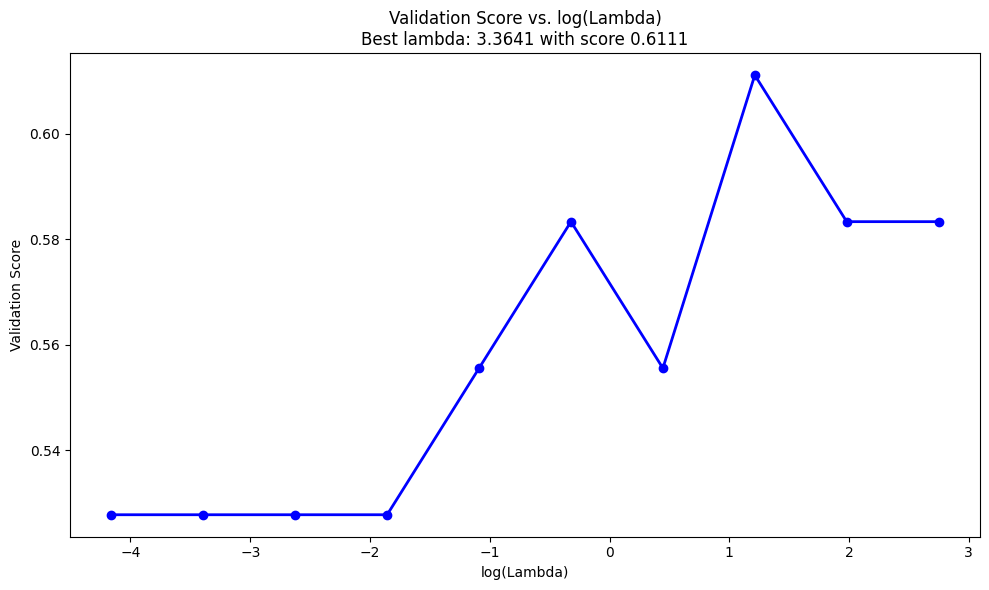

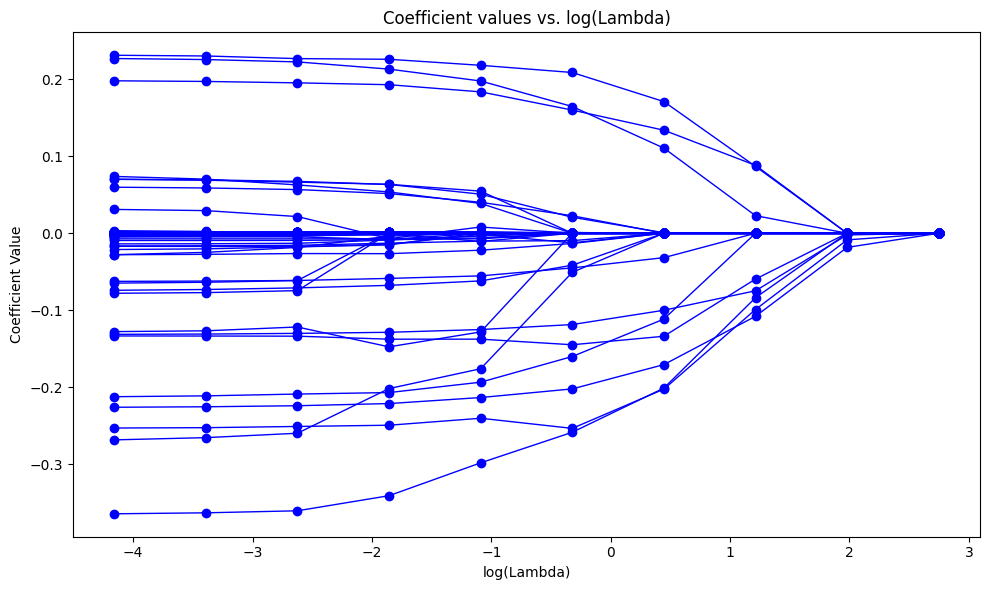

-0.3121284993478064
-----------------
Comparison with sklearn Logistic Regression: 
               metric_name  log_reg_ccd_score  log_reg_ccd_score_train  \
0           accuracy_score           0.555556                 0.598802   
1          precision_score           1.000000                 0.666667   
2             recall_score           0.111111                 0.057971   
3                 f1_score           0.200000                 0.106667   
4  balanced_accuracy_score           0.555556                 0.518781   
5            roc_auc_score           0.555556                 0.518781   
6  average_precision_score           0.555556                 0.427869   

   log_reg_none_score  log_reg_l1_score  
0            0.944444               1.0  
1            0.944444               1.0  
2            0.944444               1.0  
3            0.944444               1.0  
4            0.944444               1.0  
5            0.944444               1.0  
6            0.919753        

In [6]:
tecator_data = pd.read_csv("data/tecator.csv", header=None)
tecator_X = tecator_data.iloc[:-1, :-1]
tecator_y = (tecator_data.iloc[:-1, -1] == 'P').astype(int)

analyze_dataset(tecator_X, tecator_y, "tecator_standarize", K=10, tol=1e-3)

X_train shape:  (167, 124)
Train set target distribution (P as 1, N as 0): 0.41317365269461076
X_valid shape:  (36, 124)
X_test shape:  (36, 124)


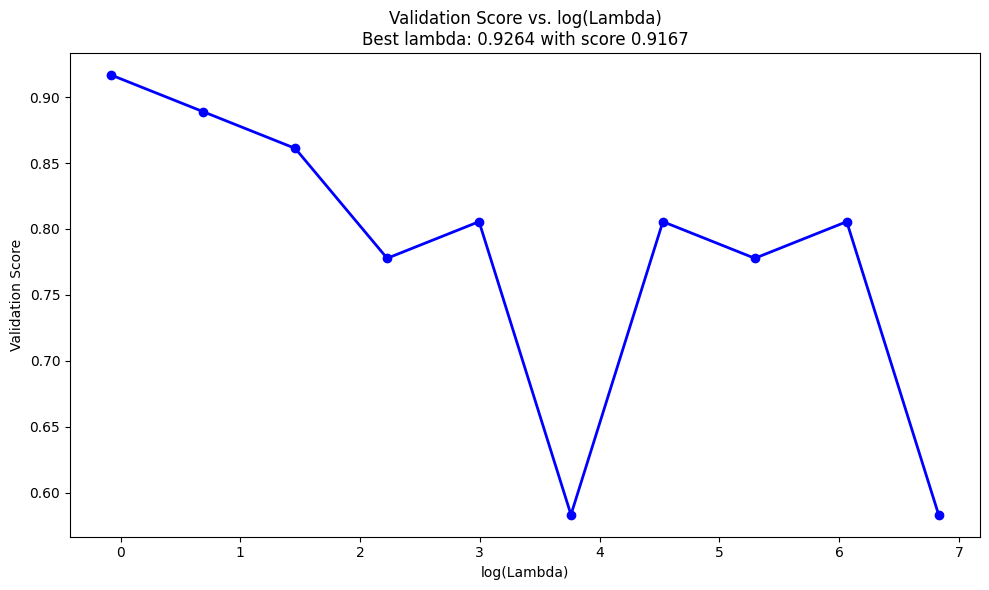

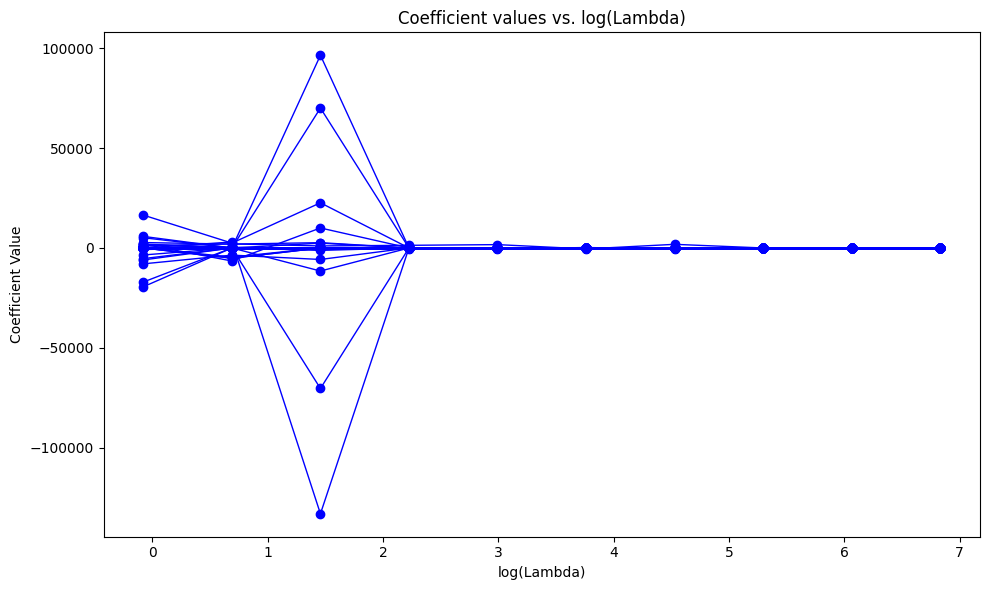

-1372.2025561076846
-----------------
Comparison with sklearn Logistic Regression: 
               metric_name  log_reg_ccd_score  log_reg_ccd_score_train  \
0           accuracy_score                1.0                 0.928144   
1          precision_score                1.0                 0.925373   
2             recall_score                1.0                 0.898551   
3                 f1_score                1.0                 0.911765   
4  balanced_accuracy_score                1.0                 0.923765   
5            roc_auc_score                1.0                 0.923765   
6  average_precision_score                1.0                 0.873411   

   log_reg_none_score  log_reg_l1_score  
0            0.944444          0.944444  
1            0.944444          0.944444  
2            0.944444          0.944444  
3            0.944444          0.944444  
4            0.944444          0.944444  
5            0.944444          0.944444  
6            0.919753        

In [8]:
analyze_dataset(tecator_X, tecator_y, "tecator_no_standarize", standarize=False, tol=1e-3)

## Sonar dataset

X_train shape:  (145, 120)
Train set target distribution (P as 1, N as 0): 0.5241379310344828
X_valid shape:  (31, 120)
X_test shape:  (32, 120)


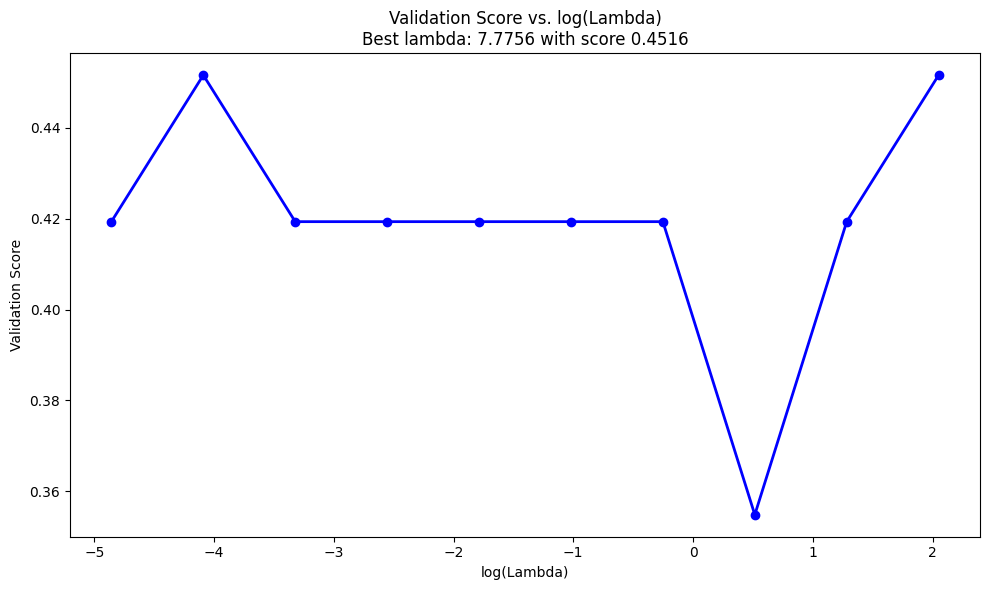

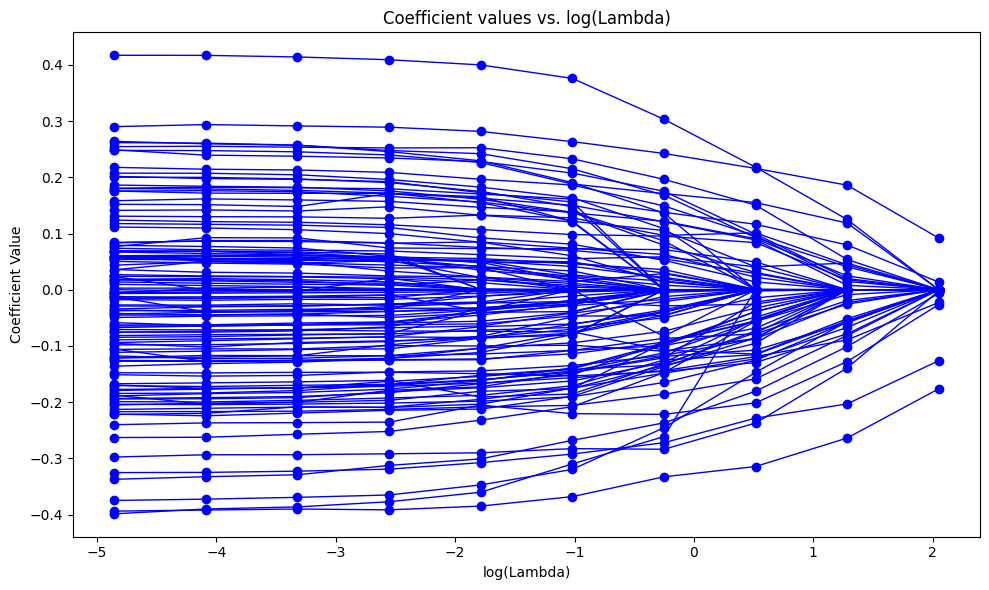

-0.49150104030175057
-----------------
Comparison with sklearn Logistic Regression: 
               metric_name  log_reg_ccd_score  log_reg_ccd_score_train  \
0           accuracy_score             0.4375                 0.468966   
1          precision_score             0.0000                 0.000000   
2             recall_score             0.0000                 0.000000   
3                 f1_score             0.0000                 0.000000   
4  balanced_accuracy_score             0.5000                 0.492754   
5            roc_auc_score             0.5000                 0.492754   
6  average_precision_score             0.5625                 0.524138   

   log_reg_none_score  log_reg_l1_score  
0            0.687500          0.718750  
1            0.722222          0.846154  
2            0.722222          0.611111  
3            0.722222          0.709677  
4            0.682540          0.734127  
5            0.682540          0.734127  
6            0.677855       

In [11]:
sonar_data = pd.read_csv("data/sonar.csv", header=None)
sonar_X = sonar_data.iloc[:, :-1]
sonar_y = (sonar_data.iloc[:, -1] == 'Mine').astype(int)


# extended with dummy variables to exceed 50% rule
sonar_X_dummy = sonar_X.copy()
for col in sonar_X_dummy.columns:
    sonar_X_dummy[col] = np.random.permutation(sonar_X_dummy[col])
sonar_X = pd.concat([sonar_X, sonar_X_dummy], axis=1)
analyze_dataset(sonar_X, sonar_y, "sonar_standarize", K=10, tol=1e-3)

X_train shape:  (145, 120)
Train set target distribution (P as 1, N as 0): 0.5241379310344828
X_valid shape:  (31, 120)
X_test shape:  (32, 120)


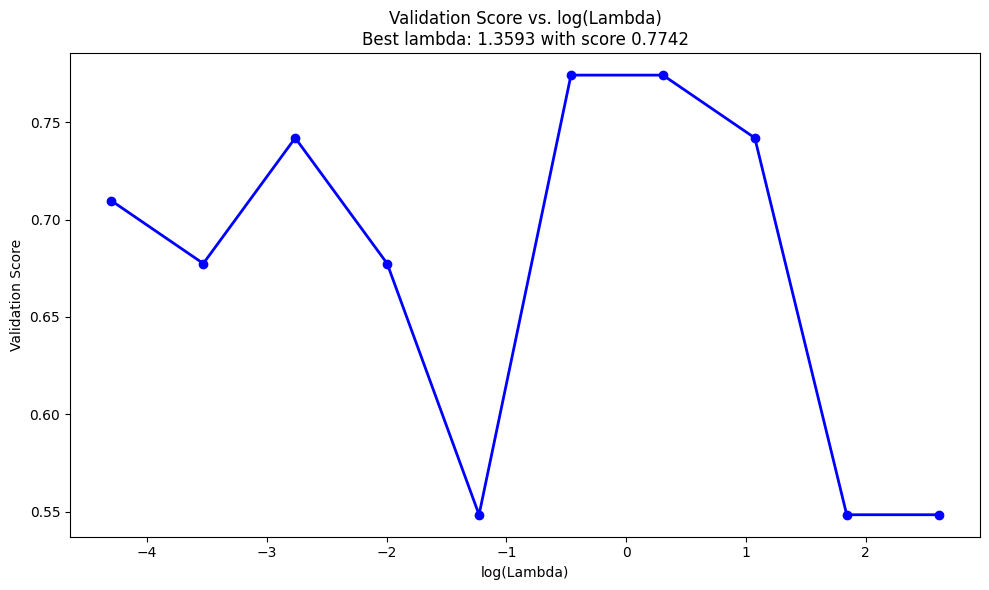

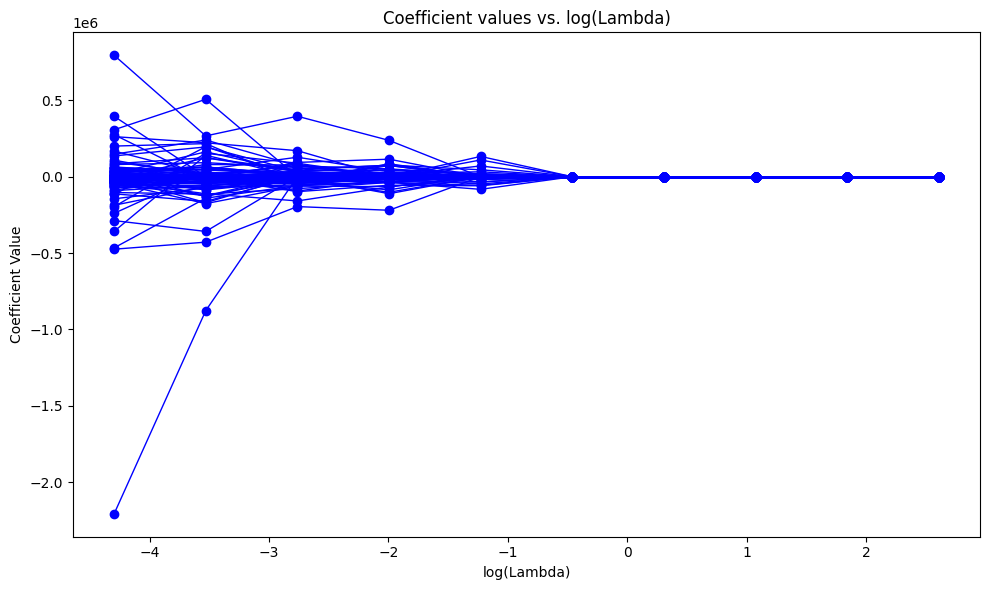

0.0589951147597456
-----------------
Comparison with sklearn Logistic Regression: 
               metric_name  log_reg_ccd_score  log_reg_ccd_score_train  \
0           accuracy_score           0.812500                 0.793103   
1          precision_score           0.800000                 0.780488   
2             recall_score           0.888889                 0.842105   
3                 f1_score           0.842105                 0.810127   
4  balanced_accuracy_score           0.801587                 0.790618   
5            roc_auc_score           0.801587                 0.790618   
6  average_precision_score           0.773611                 0.740012   

   log_reg_none_score  log_reg_l1_score  
0            0.718750          0.750000  
1            0.714286          0.812500  
2            0.833333          0.722222  
3            0.769231          0.764706  
4            0.702381          0.753968  
5            0.702381          0.753968  
6            0.688988         

In [12]:
analyze_dataset(sonar_X, sonar_y, "sonar_no_standarize", standarize=False)

## dataset4_lan_cuoi dataset

X_train shape:  (223, 256)
Train set target distribution (P as 1, N as 0): 0.5022421524663677
X_valid shape:  (48, 256)
X_test shape:  (48, 256)


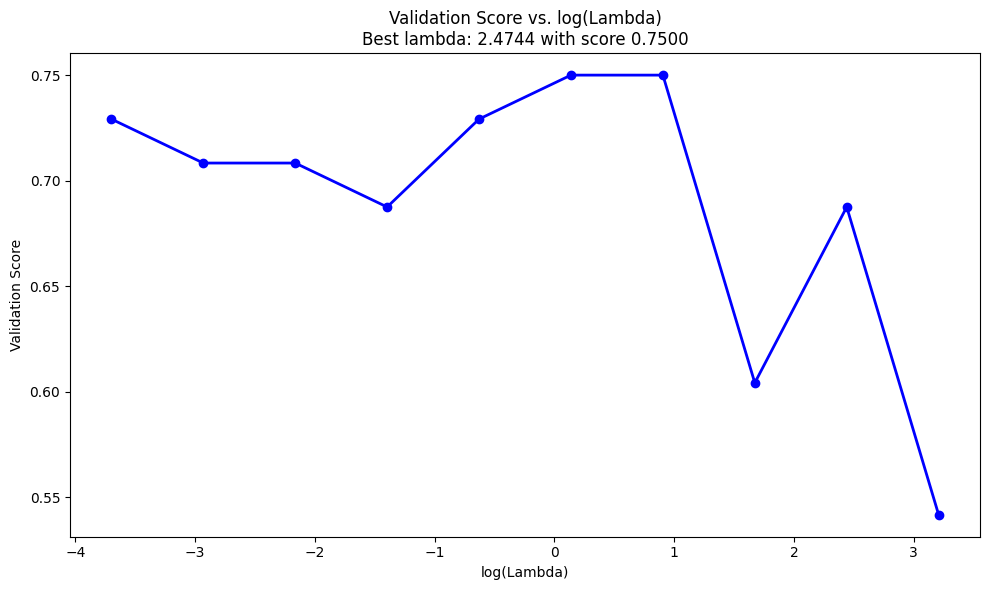

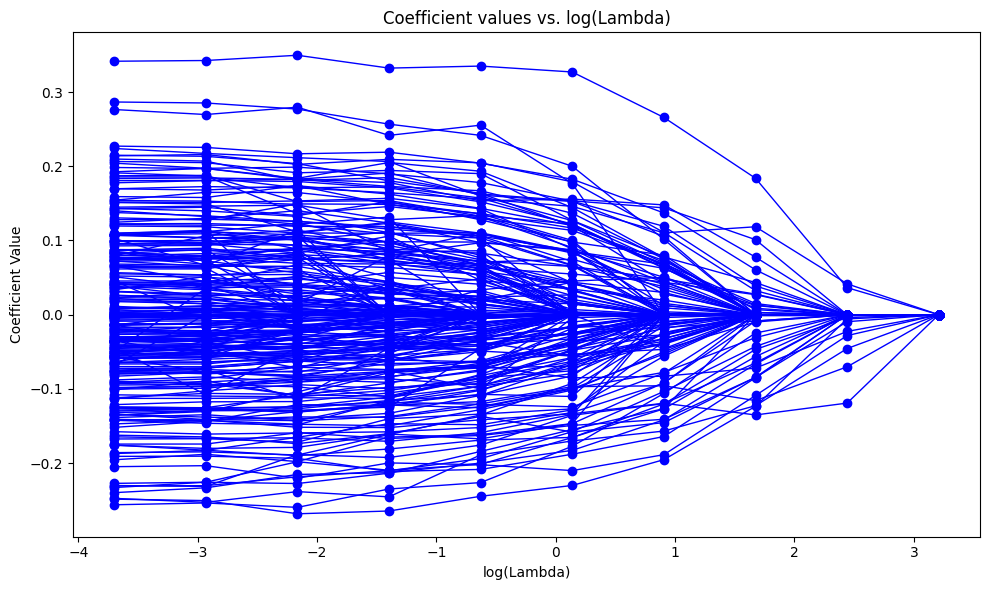

0.07405450469034837
-----------------
Comparison with sklearn Logistic Regression: 
               metric_name  log_reg_ccd_score  log_reg_ccd_score_train  \
0           accuracy_score           0.562500                 0.627803   
1          precision_score           0.480000                 0.617886   
2             recall_score           0.600000                 0.678571   
3                 f1_score           0.533333                 0.646809   
4  balanced_accuracy_score           0.567857                 0.627574   
5            roc_auc_score           0.567857                 0.627574   
6  average_precision_score           0.454667                 0.580715   

   log_reg_none_score  log_reg_l1_score  
0            0.979167          0.937500  
1            1.000000          0.904762  
2            0.950000          0.950000  
3            0.974359          0.926829  
4            0.975000          0.939286  
5            0.975000          0.939286  
6            0.970833        

In [13]:
dataset4_lan_cuoi_data = pd.read_csv("data/dataset4_lan_cuoi.csv")
dataset4_lan_cuoi_data_X = dataset4_lan_cuoi_data.drop(columns=["Class"])  # Features
dataset4_lan_cuoi_data_y = dataset4_lan_cuoi_data["Class"]                 # Label
analyze_dataset(dataset4_lan_cuoi_data_X, dataset4_lan_cuoi_data_y, "dataset4_lan_cuoi_standarize", tol=1e-3)

X_train shape:  (223, 256)
Train set target distribution (P as 1, N as 0): 0.5022421524663677
X_valid shape:  (48, 256)
X_test shape:  (48, 256)


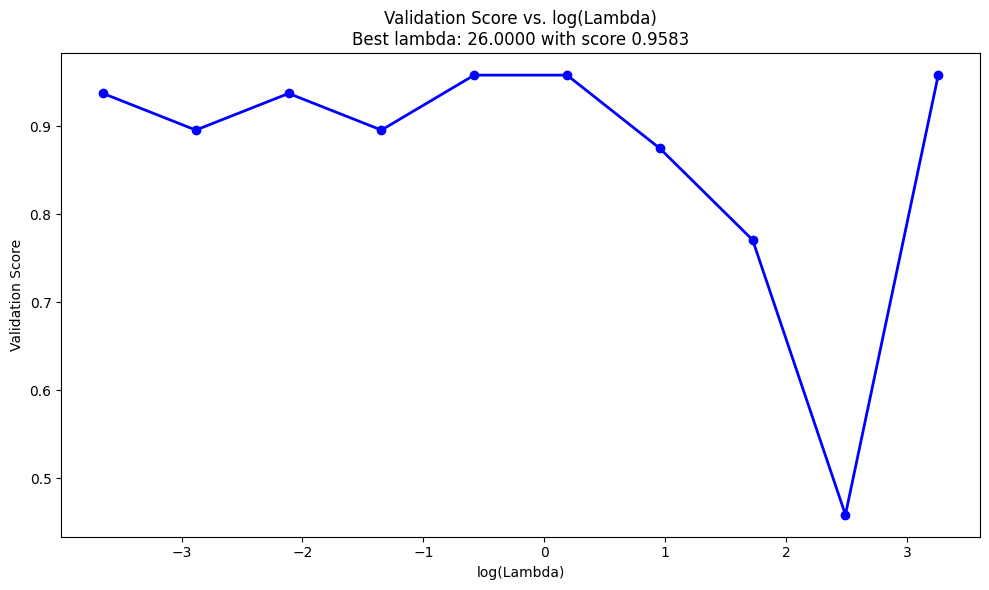

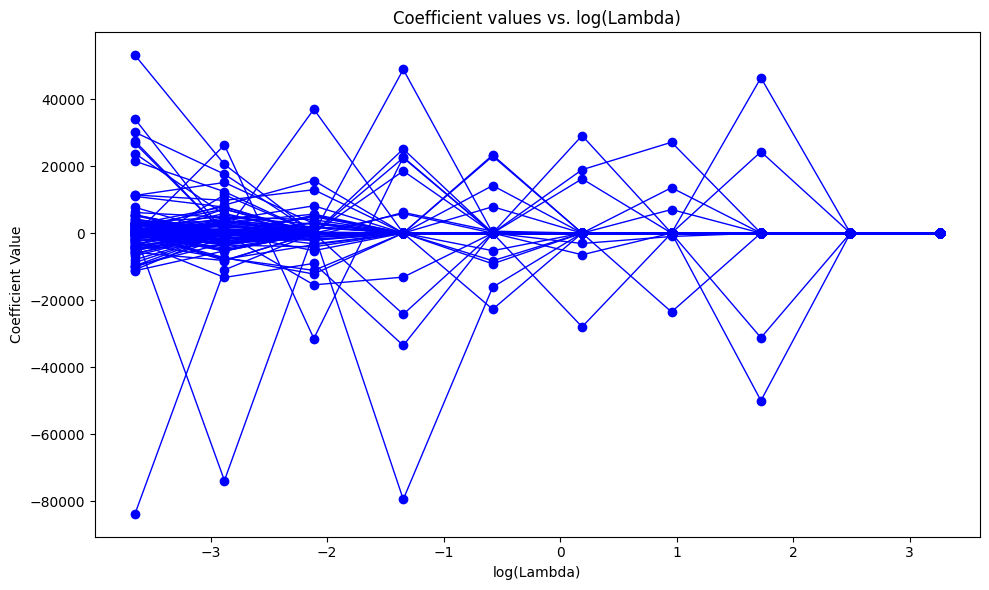

0.05413442025241898
-----------------
Comparison with sklearn Logistic Regression: 
               metric_name  log_reg_ccd_score  log_reg_ccd_score_train  \
0           accuracy_score           0.895833                 0.986547   
1          precision_score           0.941176                 0.990991   
2             recall_score           0.800000                 0.982143   
3                 f1_score           0.864865                 0.986547   
4  balanced_accuracy_score           0.882143                 0.986567   
5            roc_auc_score           0.882143                 0.986567   
6  average_precision_score           0.836275                 0.982263   

   log_reg_none_score  log_reg_l1_score  
0                 1.0          0.916667  
1                 1.0          0.863636  
2                 1.0          0.950000  
3                 1.0          0.904762  
4                 1.0          0.921429  
5                 1.0          0.921429  
6                 1.0        

In [14]:
analyze_dataset(dataset4_lan_cuoi_data_X, dataset4_lan_cuoi_data_y, "dataset4_lan_cuoi_no_standarize", standarize=False, tol=1e-3)

## Synthetic dataset

In [15]:
def generate_synthetic_data(p, n, d, g, seed=42):
    """
    Generate a synthetic dataset based on the given parameters.
    
    Parameters
    ----------
        p: float
            Prior probability for class Y=1.
        n: int
            Number of observations.
        d:  int
            Dimensionality of feature space.
        g: float 
            Covariance decay factor.
    
    Returns
    ----------
        DataFrame: A DataFrame containing generated features and class labels.
    """
    np.random.seed(seed)
    # Generate binry class variable
    y = np.random.binomial(1, p, size=n)

    # Define means for multivariate normal distribution
    mean_0 = np.zeros(d)
    mean_1 = np.array([1 / (i + 1) for i in range(d)])

    # Define covariance matrix S
    indices = np.arange(d)
    S = np.array([[g ** np.abs(i - j) for j in indices] for i in indices])
    
    # Create DataFrame
    X = np.array([
        np.random.multivariate_normal(mean_1 if y_id == 1 else mean_0, S)
        for y_id in y
    ])
    columns = [f'X{i+1}' for i in range(d)]
    X = pd.DataFrame(X, columns=columns)
    
    return X, y


### d = 2

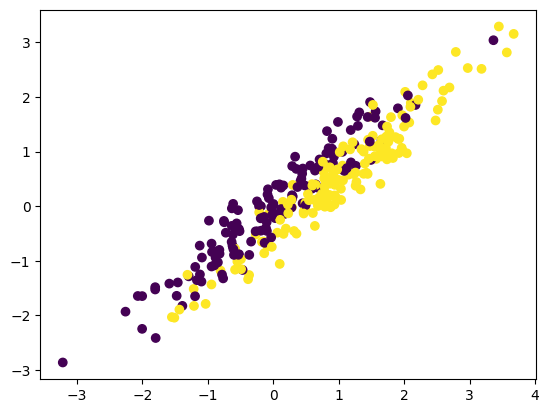

In [16]:
np.random.seed(42)
p = 0.5
n = 300
d = 2
g = 0.95

synthetic_X, synthetic_y = generate_synthetic_data(p, n, d, g)
plt.scatter(synthetic_X["X1"], synthetic_X["X2"], c=synthetic_y)
plt.show()

Accuracy score:  0.8166666666666667
Precision score:  0.75
Recall score:  0.967741935483871
F-measure score:  0.8450704225352113
Balanced Accuracy score:  0.8114571746384872
AUC-ROC score:  0.8114571746384872
AUC-PR: score:  0.7424731182795699


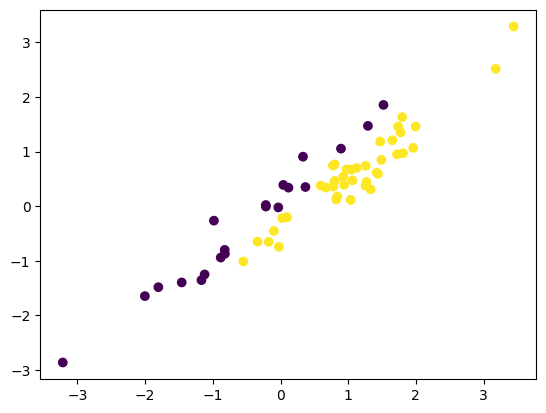

In [17]:
synthetic_X_train, synthetic_X_valid, synthetic_y_train, synthetic_y_valid = train_test_split(
    synthetic_X, synthetic_y, test_size=0.2, random_state=42, stratify=synthetic_y
)

logRegCCD = LogRegCCD()
logRegCCD = logRegCCD.fit(synthetic_X_train, synthetic_y_train, synthetic_X_valid, synthetic_y_valid)
# Get predicted probabilities
y_prob_syn = logRegCCD.predict_proba(synthetic_X_valid)

evaluate_performance(logRegCCD, synthetic_X_valid, synthetic_y_valid)

y_pred_syn = (y_prob_syn >= 0.5).astype(int)
plt.scatter(synthetic_X_valid.iloc[:,0], synthetic_X_valid.iloc[:,1], c=y_pred_syn)
plt.show()

Accuracy:  0.85
Beta:  [[ 6.20464509 -5.32413221]]
Beta zero:  [-1.66941846]


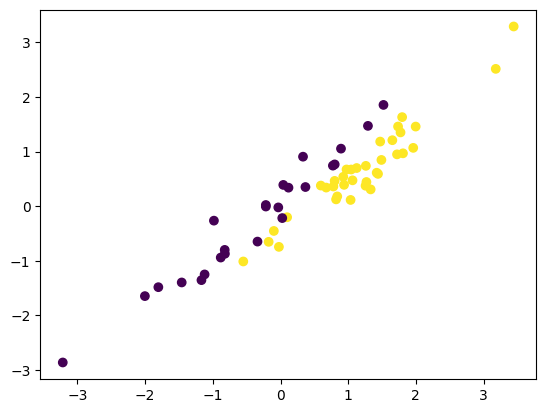

In [18]:
clf = LogisticRegression(random_state=42, penalty='none').fit(synthetic_X_train, synthetic_y_train)
print("Accuracy: ", clf.score(synthetic_X_valid, synthetic_y_valid))

print("Beta: ", clf.coef_)
print("Beta zero: ", clf.intercept_)
y_pred_lg = clf.predict(synthetic_X_valid)
plt.scatter(synthetic_X_valid.iloc[:,0], synthetic_X_valid.iloc[:,1], c=y_pred_lg)
plt.show()

### d=12

X_train shape:  (210, 12)
Train set target distribution (P as 1, N as 0): 0.5285714285714286
X_valid shape:  (45, 12)
X_test shape:  (45, 12)


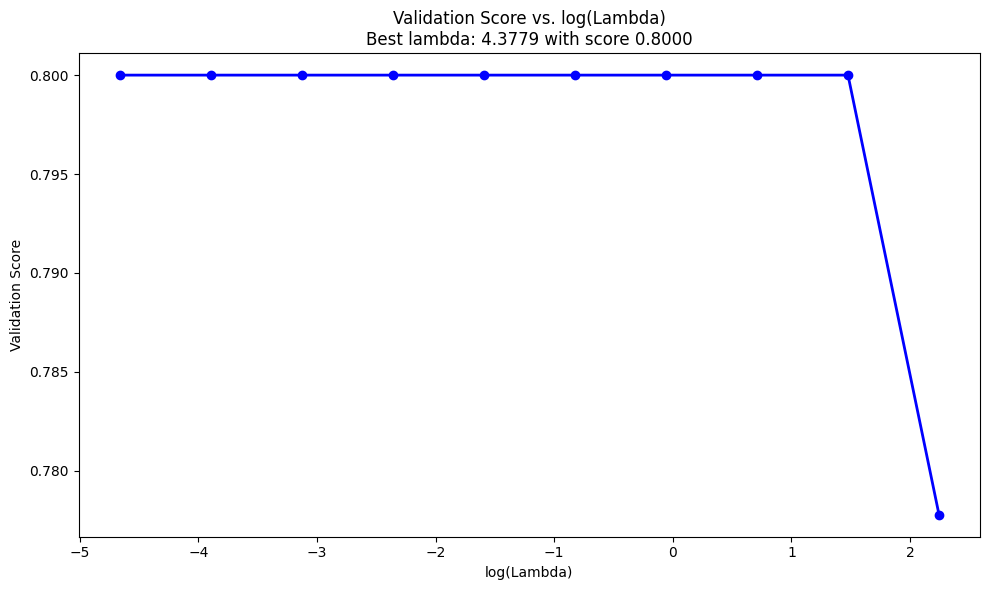

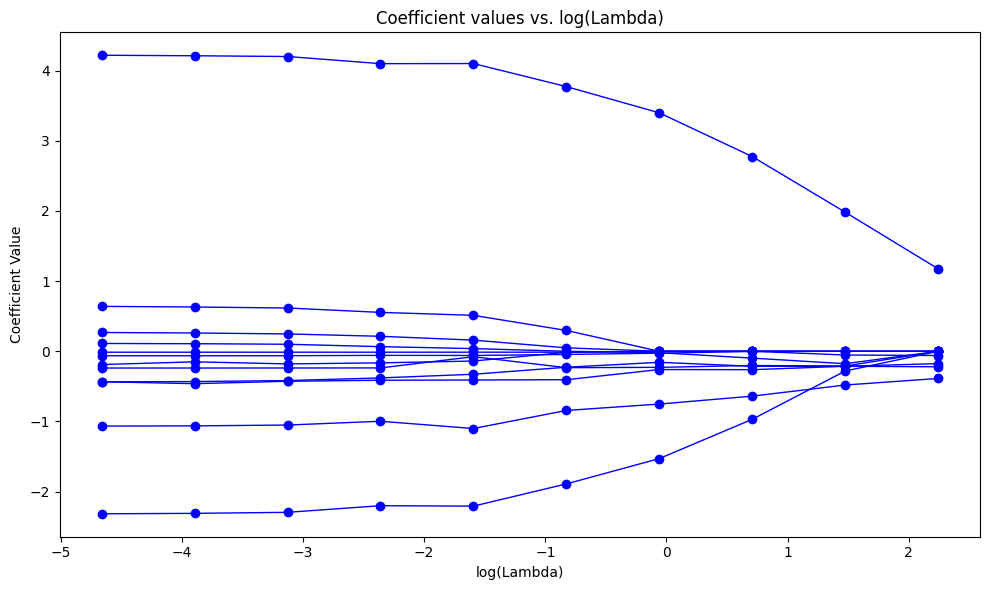

0.0856004252041328
-----------------
Comparison with sklearn Logistic Regression: 
               metric_name  log_reg_ccd_score  log_reg_ccd_score_train  \
0           accuracy_score           0.644444                 0.780952   
1          precision_score           0.666667                 0.828283   
2             recall_score           0.545455                 0.738739   
3                 f1_score           0.600000                 0.780952   
4  balanced_accuracy_score           0.642292                 0.783511   
5            roc_auc_score           0.642292                 0.783511   
6  average_precision_score           0.585859                 0.749980   

   log_reg_none_score  log_reg_l1_score  
0            0.711111          0.711111  
1            0.764706          0.764706  
2            0.590909          0.590909  
3            0.666667          0.666667  
4            0.708498          0.708498  
5            0.708498          0.708498  
6            0.651872         

In [20]:
np.random.seed(42)
p = 0.5
n = 300
d = 12
g = 0.95

synthetic_X, synthetic_y = generate_synthetic_data(p, n, d, g)
analyze_dataset(synthetic_X, synthetic_y, "synthetic_standarize", tol=1e-3)

X_train shape:  (210, 12)
Train set target distribution (P as 1, N as 0): 0.5285714285714286
X_valid shape:  (45, 12)
X_test shape:  (45, 12)


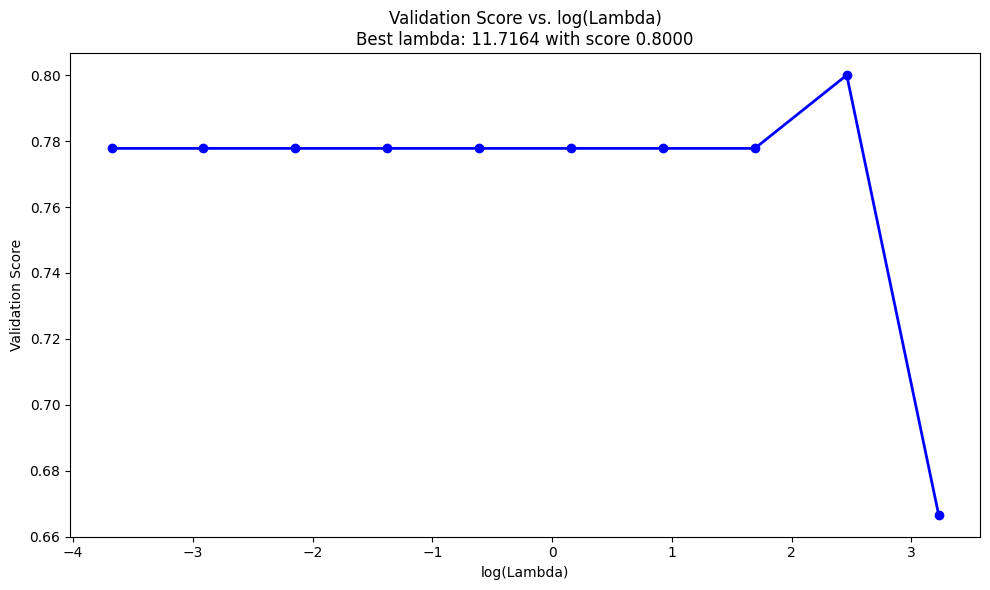

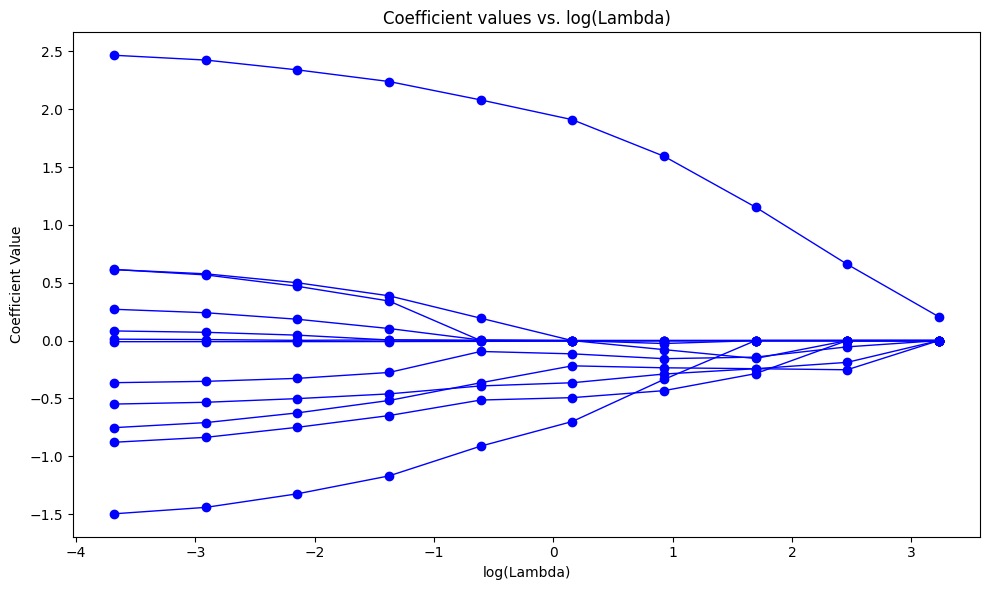

0.06224856908602737
-----------------
Comparison with sklearn Logistic Regression: 
               metric_name  log_reg_ccd_score  log_reg_ccd_score_train  \
0           accuracy_score           0.622222                 0.695238   
1          precision_score           0.586207                 0.645963   
2             recall_score           0.772727                 0.936937   
3                 f1_score           0.666667                 0.764706   
4  balanced_accuracy_score           0.625494                 0.680590   
5            roc_auc_score           0.625494                 0.680590   
6  average_precision_score           0.564089                 0.638560   

   log_reg_none_score  log_reg_l1_score  
0            0.711111          0.688889  
1            0.764706          0.722222  
2            0.590909          0.590909  
3            0.666667          0.650000  
4            0.708498          0.686759  
5            0.708498          0.686759  
6            0.651872        

In [21]:

analyze_dataset(synthetic_X, synthetic_y, "synthetic_no_standarize", tol=1e-3, standarize=False)

## fri_c4_250_100
 

In [25]:
df_3 = pd.read_csv("./data/dataset3_(lan_cuoi).csv")  

# Separate features and labels (label: 'binaryClass')
# Split the DataFrame into two parts: X_3 (features) and y_3 (labels).
# The 'binaryClass' column is the label, while the rest are the features.
X_3 = df_3.drop(columns=["binaryClass"])  # Features
y_3 = df_3["binaryClass"]                 # Label

X_train shape:  (175, 100)
Train set target distribution (P as 1, N as 0): 0.45714285714285713
X_valid shape:  (37, 100)
X_test shape:  (38, 100)


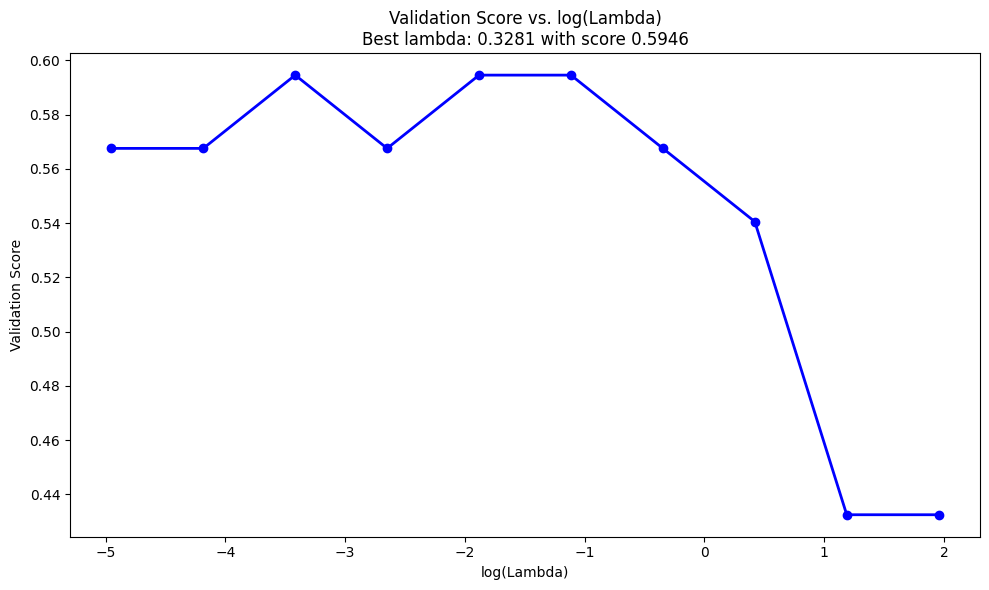

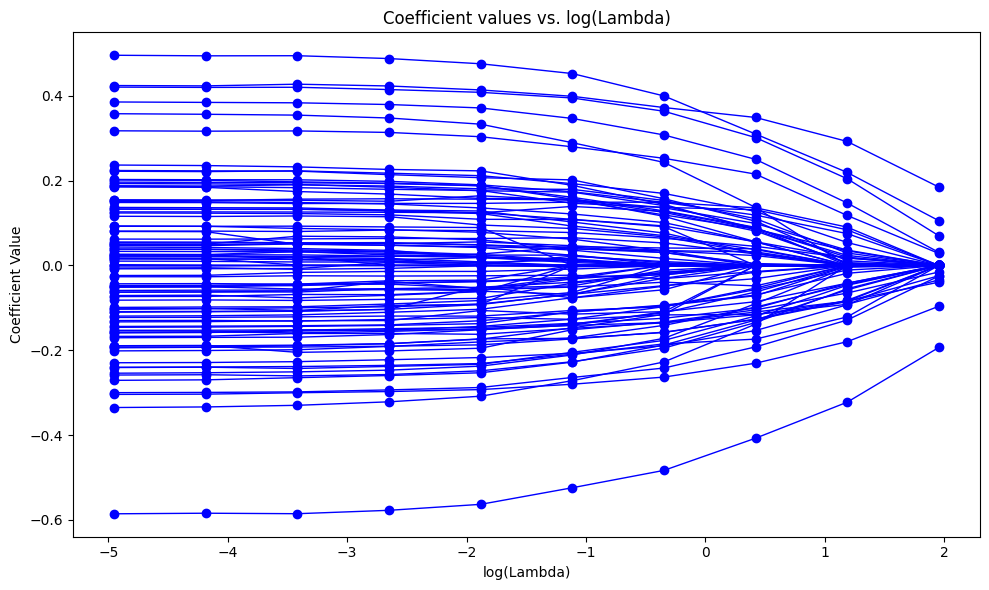

-0.06493245559943309
-----------------
Comparison with sklearn Logistic Regression: 
               metric_name  log_reg_ccd_score  log_reg_ccd_score_train  \
0           accuracy_score           0.342105                 0.497143   
1          precision_score           0.166667                 0.451220   
2             recall_score           0.230769                 0.462500   
3                 f1_score           0.193548                 0.456790   
4  balanced_accuracy_score           0.315385                 0.494408   
5            roc_auc_score           0.315385                 0.494408   
6  average_precision_score           0.301619                 0.454403   

   log_reg_none_score  log_reg_l1_score  
0            0.526316          0.605263  
1            0.368421          0.437500  
2            0.538462          0.538462  
3            0.437500          0.482759  
4            0.529231          0.589231  
5            0.529231          0.589231  
6            0.356275       

In [26]:
analyze_dataset(X_3, y_3, "df3_standarize", tol=1e-3)

X_train shape:  (175, 100)
Train set target distribution (P as 1, N as 0): 0.45714285714285713
X_valid shape:  (37, 100)
X_test shape:  (38, 100)


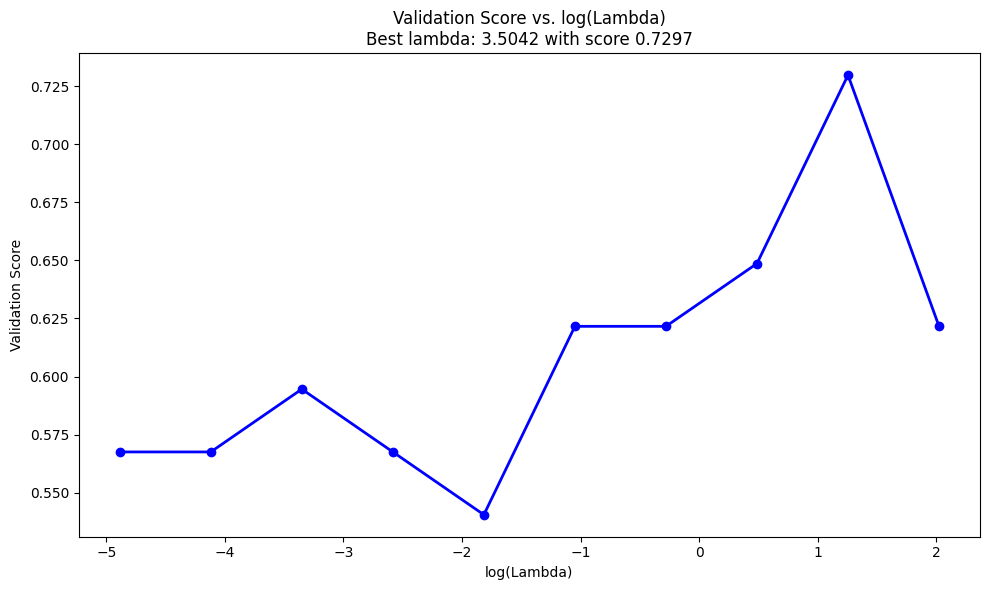

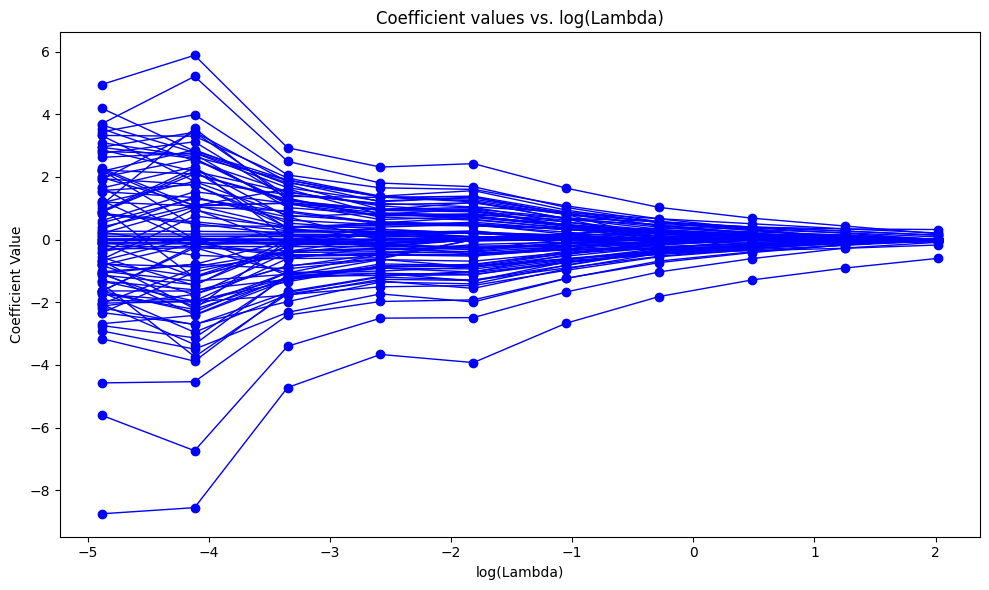

-0.15214578503876391
-----------------
Comparison with sklearn Logistic Regression: 
               metric_name  log_reg_ccd_score  log_reg_ccd_score_train  \
0           accuracy_score           0.578947                 0.834286   
1          precision_score           0.384615                 0.822785   
2             recall_score           0.384615                 0.812500   
3                 f1_score           0.384615                 0.817610   
4  balanced_accuracy_score           0.532308                 0.832566   
5            roc_auc_score           0.532308                 0.832566   
6  average_precision_score           0.358455                 0.754227   

   log_reg_none_score  log_reg_l1_score  
0            0.526316          0.605263  
1            0.368421          0.428571  
2            0.538462          0.461538  
3            0.437500          0.444444  
4            0.529231          0.570769  
5            0.529231          0.570769  
6            0.356275       

In [27]:
analyze_dataset(X_3, y_3, "df3_no_standarize", tol=1e-3, standarize=False)